![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 03: Keras API advanced
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Advanced Data Analysis (30-03-2020)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-advanced-data-analysis-2020/blob/master/S03_TF_intro/03_Advanced_Data_Analysis_Keras_API_advanced_NOTsolved.ipynb)

**Resources (code patched and updated from):**
* Sklearn
* TensorFlow Authors
* Talos documentation
* Aurelien Geron's O'Reilly's "Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow"

## Installing and using Talos

**WARNING!!** Don't do `!pip install talos`, with the change to tensorflow 2.0 we need to ensure that we install Talos 1.0



In [0]:
# Install in your environment at your convenience
!pip install git+https://github.com/autonomio/talos@1.0

  Cloning https://github.com/autonomio/talos (to revision 1.0) to /tmp/pip-req-build-k1m2786y
  Running command git clone -q https://github.com/autonomio/talos /tmp/pip-req-build-k1m2786y
  Running command git checkout -b 1.0 --track origin/1.0
  Switched to a new branch '1.0'
  Branch '1.0' set up to track remote branch '1.0' from 'origin'.
     |████████████████████████████████| 8.7MB 1.4MB/s 
     |████████████████████████████████| 839kB 40.3MB/s 
  Created wheel for talos: filename=talos-1.0-cp36-none-any.whl size=53700 sha256=f32efeaa0d8066208a385e7c8e16145edfcef78d77e3fe5440b54ac47074681b
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8ihavdc/wheels/9f/14/d1/e58012a97c43cf2148959890b171f49e4a5e1c82a9946b2c22
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=a63a3efe894472113f1b701094abf6889512c0f87bce59d0c696869f9cbc84cb
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wh

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Import Keras from TensorFlow
from tensorflow import keras

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Import talos after all
import talos

ModuleNotFoundError: ignored

# Hyperparameter Tuning

UUID - #S3C1

Let's load, split and scale the California housing dataset

In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

## Using Talos

Talos allows us to use Keras model as is, but introducing the whole pipeline in a function as such.

Talos works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works.

For this example, we have to import two helper functions from Talos, one for early stopping callout, and the other for using normalized learning rate values. Because we might want to work on trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome.

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels.


In [0]:
from talos.utils import lr_normalizer

In [0]:
# then we can go ahead and set the parameter space

from tensorflow.keras.optimizers import Adam, Nadam, SGD


p = {'lr': (0.001, 0.01, 0.1, 10, 10),
     'activation':['relu', 'elu'], 
     'optimizer': [Adam, Nadam, SGD], 
     'losses': ['mse', 'mae'], 
     'shapes': ['brick'], 
     'first_neuron': [32, 64], 
     'hidden_layers':[1, 2, 3], 
     'dropout': [0], 
     'batch_size': [20],
     'epochs': [100]}

In [0]:
X_train_scaled.shape

(15480, 8)

In [0]:
X_valid.shape

(3870, 8)

In [0]:
from talos.utils import hidden_layers
from talos.utils import lr_normalizer

def houses_model(x_train, y_train, x_val, y_val, params):

    #Starting our Sequential model
    model = keras.models.Sequential()

    # Add the first layer with the input shape
    #model.add(keras.layers.Dense(units=x_train.shape[0], input_shape=(8,)))
    model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))

    # Add the Talos hidden layers method
    hidden_layers(model, params, 1)

    model.add(keras.layers.Dense(1, name='Output'))

    keras.utils.plot_model(model, "my_multipleinput_model.png", show_shapes=True)

    # Create a model compilation 
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['losses'],
                  metrics=['mse'])
    
    print(model.summary())

    # Use a validation split here since it seems that passing validation to Scan object is broken
    out = model.fit(x_train, y_train, validation_split=0.3, 
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=2,
                    callbacks=[talos.utils.early_stopper(params['epochs'], 
                                                         monitor='mse', 
                                                         patience='10')])
    
    return out, model

### Run the Hyperparameter search

Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/100 of the entire permutations.

**BEWARE!!!** Since Sklearn is not stable... it seems that Talos is not doing well. The whole transfer to TF 2.x is costing quite a bit cumbersome for many libraries... in this specific case , do not pass `x_val` and `y_val` to the Scan object. Rather pass a `validation.split` in the build model function above.

In [0]:
scan_object = talos.Scan(x=X_train_scaled,
                         y=y_train, 
                         params=p, 
                         model=houses_model, 
                         experiment_name='my_exp', 
                         fraction_limit=.3, 
                         reduction_metric='val_mse')










































































  0%|          | 0/21 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                










































































  5%|▍         | 1/21 [01:14<24:48, 74.41s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 5.5920 - mse: 5.5899 - val_loss: 5.7163 - val_mse: 5.7165
Epoch 2/100
380/380 - 1s - loss: 5.4012 - mse: 5.4035 - val_loss: 5.5275 - val_mse: 5.5277
Epoch 3/100
380/380 - 1s - loss: 5.2209 - mse: 5.2243 - val_loss: 5.3460 - val_mse: 5.3462
Epoch 4/100
380/380 - 1s - loss: 5.0442 - mse: 5.0522 - val_loss: 5.1715 - val_mse: 5.1718
Epoch 5/100
380/380










































































 10%|▉         | 2/21 [02:18<22:33, 71.26s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 6










































































 14%|█▍        | 3/21 [03:36<22:01, 73.44s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 7.8142 - mse: 7.8101 - val_loss: 7.9900 - val_mse: 7.9898
Epoch 2/100
380/380 - 1s










































































 19%|█▉        | 4/21 [04:43<20:13, 71.40s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 2.7806 - mse: 9.5763 - val_loss: 2.8151 - val_mse: 9.8221
Epoch 2/100
380/380 - 1s - loss: 2.7680 - mse: 9.5008 - val_loss: 2.8030 - val_mse: 9.7460
Epoch 3/100
380/380 - 1s - loss: 2.7557 - mse: 9.4256 - val_loss: 2.7910 - val_mse: 9.6703
Epoch 4/100
380/380 - 1s - loss: 2.7422 - mse: 9.3513 - val_loss: 2.7790 - val_mse: 9.5950
Epoch 5/100
380/380










































































 24%|██▍       | 5/21 [05:50<18:43, 70.22s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 4.3484 - mse: 4.3444 - val_loss: 4.6987 - val_mse: 4.6996
Epoch 2/100
380/380 - 1s - loss: 4.3243 - mse: 4.3279 - val_loss: 4.6820 - val_mse: 4.6829
Epoch 3/100
380/380 - 1s - loss: 4.3083 - mse: 4.3117 - val_loss: 4.6654 - val_mse: 4.6663
Epoch 4/100
380/380 - 1s - loss: 4.2887 - mse: 4.2955 - val_loss: 4.6487 - val_mse: 4.6497
Epoch 5/100
380/380










































































 29%|██▊       | 6/21 [06:55<17:06, 68.41s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 3










































































 33%|███▎      | 7/21 [08:09<16:24, 70.32s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 6.2614 - mse: 6.2583 - val_loss: 6.3718 - val_mse: 6.3708
Epoch 2/100
380/380 - 1s










































































 38%|███▊      | 8/21 [09:15<14:55, 68.86s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 5.1724 - mse: 5.1695 - val_loss: 5.3120 - val_mse: 5.3132
Epoch 2/100
380/380 - 1s










































































 43%|████▎     | 9/21 [10:29<14:05, 70.49s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 2.1436 - mse: 6.0551 - val_loss: 2.1767 - val_mse: 6.2939
Epoch 2/100
380/380 - 1s










































































 48%|████▊     | 10/21 [11:36<12:44, 69.50s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 2.1440 - mse: 6.1770 - val_loss: 2.1805 - val_mse: 6.4586
Epoch 2/100
380/380 - 1s - loss: 2.1385 - mse: 6.1545 - val_loss: 2.1750 - val_mse: 6.4362
Epoch 3/100
380/380 - 1s - loss: 2.1327 - mse: 6.1322 - val_loss: 2.1695 - val_mse: 6.4138
Epoch 4/100
380/380 - 1s - loss: 2.1259 - mse: 6.1102 - val_loss: 2.1640 - val_mse: 6.3916
Epoch 5/100
380/380










































































 52%|█████▏    | 11/21 [12:41<11:19, 67.95s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 6.5005 - mse: 6.4951 - val_loss: 6.4415 - val_mse: 6.4445
Epoch 2/100
380/380 - 1s - loss: 6.1927 - mse: 6.1972 - val_loss: 6.1494 - val_mse: 6.1523
Epoch 3/100
380/380 - 1s - loss: 5.9127 - mse: 5.9173 - val_loss: 5.8743 - val_mse: 5.8773
Epoch 4/100
380/380 - 1s - loss: 5.6474 - mse: 5.6539 - val_loss: 5.6154 - val_mse: 5.6184
Epoch 5/100
380/380










































































 57%|█████▋    | 12/21 [13:44<10:00, 66.70s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 4.8188 - mse: 4.8172 - val_loss: 4.9032 - val_mse: 4.9066
Epoch 2/100
380/380 - 1s










































































 62%|██████▏   | 13/21 [14:57<09:06, 68.33s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 1.9463 - mse: 4.9432 - val_loss: 1.9446 - val_mse: 5.0721
Epoch 2/100
380/380 - 1s - loss: 1.9371 - mse: 4.9164 - val_loss: 1.9380 - val_mse: 5.0460
Epoch 3/100
380/380 - 1s - loss: 1.9309 - mse: 4.8896 - val_loss: 1.9313 - val_mse: 5.0200
Epoch 4/100
380/380 - 1s - loss: 1.9236 - mse: 4.8628 - val_loss: 1.9246 - val_mse: 4.9940
Epoch 5/100
380/380










































































 67%|██████▋   | 14/21 [16:05<07:58, 68.32s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 6.0191 - mse: 6.0166 - val_loss: 6.1563 - val_mse: 6.1587
Epoch 2/100
380/380 - 1s - loss: 5.9868 - mse: 5.9907 - val_loss: 6.1295 - val_mse: 6.1319
Epoch 3/100
380/380 - 1s - loss: 5.9611 - mse: 5.9648 - val_loss: 6.1028 - val_mse: 6.1052
Epoch 4/100
380/380 - 1s - loss: 5.9311 - mse: 5.9391 - val_loss: 6.0761 - val_mse: 6.0785
Epoch 5/100
380/380










































































 71%|███████▏  | 15/21 [17:13<06:49, 68.21s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 2.0635 - mse: 5.9093 - val_loss: 2.0960 - val_mse: 6.1402
Epoch 2/100
380/380 - 1s










































































 76%|███████▌  | 16/21 [18:20<05:38, 67.77s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 6










































































 81%|████████  | 17/21 [19:40<04:46, 71.54s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 6










































































 86%|████████▌ | 18/21 [20:59<03:41, 73.68s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 4.5606 - mse: 4.5565 - val_loss: 4.6970 - val_mse: 4.6976
Epoch 2/100
380/380 - 1s










































































 90%|█████████ | 19/21 [22:11<02:26, 73.26s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 2.0443 - mse: 5.1327 - val_loss: 2.0520 - val_mse: 5.1972
Epoch 2/100
380/380 - 1s










































































 95%|█████████▌| 20/21 [23:27<01:14, 74.02s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
380/380 - 1s - loss: 5.3862 - mse: 5.3838 - val_loss: 5.6094 - val_mse: 5.6103
Epoch 2/100
380/380 - 1s - loss: 5.3362 - mse: 5.3404 - val_loss: 5.5641 - val_mse: 5.5650
Epoch 3/100
380/380 - 1s - loss: 5.2930 - mse: 5.2973 - val_loss: 5.5190 - val_mse: 5.5200
Epoch 4/100
380/380 - 1s - loss: 5.2477 - mse: 5.2546 - val_loss: 5.4744 - val_mse: 5.4754
Epoch 5/100
380/380










































































100%|██████████| 21/21 [24:35<00:00, 70.25s/it]


### Check the results from Scan

In [0]:
# accessing the results data frame
scan_object.data.head()

,start,end,duration,round_epochs,loss,mse,val_loss,val_mse,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,losses,lr,optimizer,shapes
0,03/29/20-225448,03/29/20-225602,74.184704,100,0.701878,1.005612,0.707667,1.003745,elu,20,0,100,32,3,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
1,03/29/20-225602,03/29/20-225706,63.696198,100,0.729934,0.730945,0.743067,0.744447,elu,20,0,100,64,1,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick
2,03/29/20-225706,03/29/20-225825,78.316898,100,1.192151,1.194020,1.257920,1.259226,relu,20,0,100,64,3,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
3,03/29/20-225825,03/29/20-225931,66.415177,100,0.951792,0.953028,0.983768,0.984797,relu,20,0,100,32,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick
4,03/29/20-225932,03/29/20-230039,67.255532,100,1.685242,4.186103,1.722976,4.352967,relu,20,0,100,32,1,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.n...,brick


In [0]:
# accessing epoch entropy values for each round
scan_object.learning_entropy

,loss,mse
0,0.000003,1.557824e-05
1,0.000004,2.432996e-06
2,0.000029,3.058036e-05
3,0.000017,1.895860e-05
4,0.000003,7.840127e-06
5,0.000023,2.389976e-05
6,0.000093,8.724167e-05
7,0.000155,1.731936e-04
8,0.000359,3.742007e-04
9,0.000004,3.072257e-06


In [0]:

# access the summary details
scan_object.details

experiment_name                  my_exp
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_mse
complete_time            03/29/20/23:19
x_shape                      (15480, 8)
y_shape                        (15480,)
dtype: object

In addition to statistics and meta-data related with the Scan, the used data (x and y) together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object.

In [0]:
# accessing the saved models
scan_object.saved_models

['{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "dtype": "float32", "units": 32, "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null, "batch_input_shape": [null, 8]}}, {"class_name": "Dropout", "config": {"name": "dropout_2", "trainable": true, "dtype": "float32", "rate": 0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_3", "trainable": true, "dtype": "float32", "units": 32, "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regu

In [0]:
# accessing the saved weights for models
scan_object.saved_weights

[[array([[ 0.13790904, -0.33760086,  0.08386634, -0.03706633,  0.37529024,
           0.34208703,  0.08438694, -0.33212733, -0.29940102, -0.09167956,
           0.1439695 ,  0.04062584,  0.28474128, -0.01372045,  0.02852014,
          -0.07566615,  0.3310445 , -0.22987725, -0.25982893, -0.32808533,
          -0.00442374,  0.15660849, -0.3494835 , -0.3208565 ,  0.3578102 ,
          -0.21375912,  0.28686765, -0.12571412,  0.29847762,  0.13801068,
          -0.32599643,  0.05314669],
         [-0.01840215,  0.13348971,  0.30220243, -0.21435821, -0.39327326,
           0.19965827, -0.3239289 , -0.00202691, -0.2568516 ,  0.10753122,
           0.18386522,  0.13797103, -0.0784177 ,  0.36907834,  0.27507246,
           0.30391604, -0.40162173,  0.14887421,  0.07375609, -0.30301887,
           0.3620058 , -0.0424925 , -0.08110006,  0.15641741,  0.23126683,
          -0.32670546, -0.10358158,  0.21574935, -0.1894446 ,  0.13040686,
           0.2982007 , -0.14699031],
         [ 0.36428654,  0.

### Using Reporting()
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

In [0]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [0]:
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,mse,val_loss,val_mse,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,losses,lr,optimizer,shapes
0,03/29/20-225448,03/29/20-225602,74.184704,100,0.701878,1.005612,0.707667,1.003745,elu,20,0,100,32,3,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
1,03/29/20-225602,03/29/20-225706,63.696198,100,0.729934,0.730945,0.743067,0.744447,elu,20,0,100,64,1,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick
2,03/29/20-225706,03/29/20-225825,78.316898,100,1.192151,1.194020,1.257920,1.259226,relu,20,0,100,64,3,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
3,03/29/20-225825,03/29/20-225931,66.415177,100,0.951792,0.953028,0.983768,0.984797,relu,20,0,100,32,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick
4,03/29/20-225932,03/29/20-230039,67.255532,100,1.685242,4.186103,1.722976,4.352967,relu,20,0,100,32,1,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.n...,brick
5,03/29/20-230039,03/29/20-230143,63.983262,100,2.993923,2.997629,3.319123,3.320611,relu,20,0,100,32,1,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
6,03/29/20-230143,03/29/20-230258,74.553571,100,1.778293,1.780283,1.760582,1.762643,elu,20,0,100,32,3,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick
7,03/29/20-230258,03/29/20-230403,65.255099,100,0.650136,0.650901,0.694784,0.696294,elu,20,0,100,32,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick
8,03/29/20-230403,03/29/20-230517,74.075158,100,0.810759,0.811942,0.903872,0.905537,relu,20,0,100,64,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.n...,brick
9,03/29/20-230518,03/29/20-230625,66.990948,100,1.133847,2.307838,1.161780,2.417095,relu,20,0,100,64,2,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick


In [0]:
# get the number of rounds in the Scan
analyze_object.rounds()

21

In [0]:
# get the highest result for any metric
analyze_object.high('mse')

4.340416431427002

In [0]:
# get the lowest result for any metric
analyze_object.low('mse')

0.6434736251831055

In [0]:
# get the round with the best result
analyze_object.rounds2high('val_mse')

10

In [0]:
# get the best paramaters
analyze_object.best_params(metric='mse', exclude=['loss'])

array([[1, 64.11499953269958, 1.6951704025268555, 0, 100, 0.001, 'brick',
        '03/29/20-230729', 20, 'relu', 100, 'mae',
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        4.620042324066162, 32, '03/29/20-230625', 0],
       [1, 67.25553154945374, 1.7229764461517334, 0, 100, 0.001, 'brick',
        '03/29/20-230039', 20, 'relu', 100, 'mae',
        <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>,
        4.352967262268066, 32, '03/29/20-225932', 1],
       [1, 67.72818922996521, 3.9226253032684326, 0, 100, 0.001, 'brick',
        '03/29/20-231201', 20, 'elu', 100, 'mse',
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        3.924560785293579, 64, '03/29/20-231053', 2],
       [1, 63.98326230049133, 3.319122791290283, 0, 100, 0.001, 'brick',
        '03/29/20-230143', 20, 'relu', 100, 'mse',
        <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
        3.320610761642456, 32, '03/29/20-230039', 3],
       [1, 68.093326

In [0]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_mse', ['epochs', 'round_epochs', 'batch_size', 'dropout'])

duration        -4.414739e-01
loss             7.394133e-01
mse              9.987491e-01
val_loss         7.284959e-01
first_neuron    -2.943610e-01
hidden_layers   -5.836093e-01
lr              -1.016288e-16
Name: val_mse, dtype: float64

### Visualizing Reporting()

In addition to the key obsevations, several useful plots are available for analysis of the results.

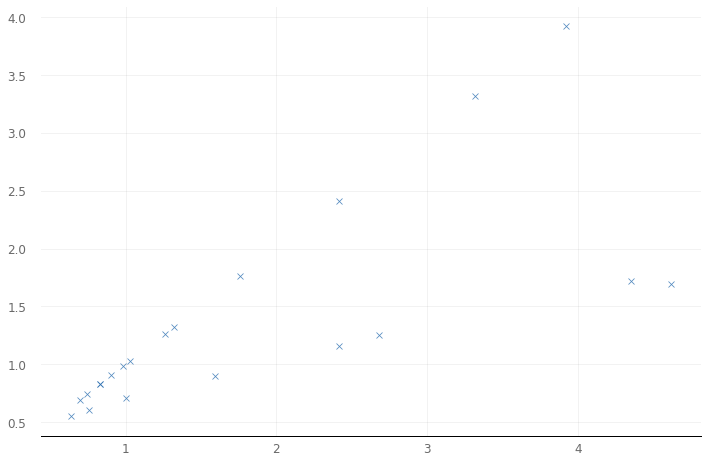

In [0]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_mse', 'val_loss')

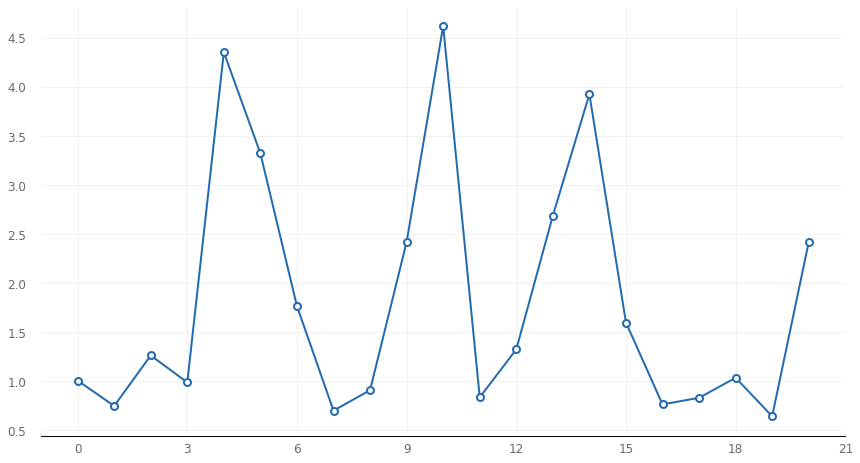

In [0]:
# line plot
analyze_object.plot_line('val_mse')

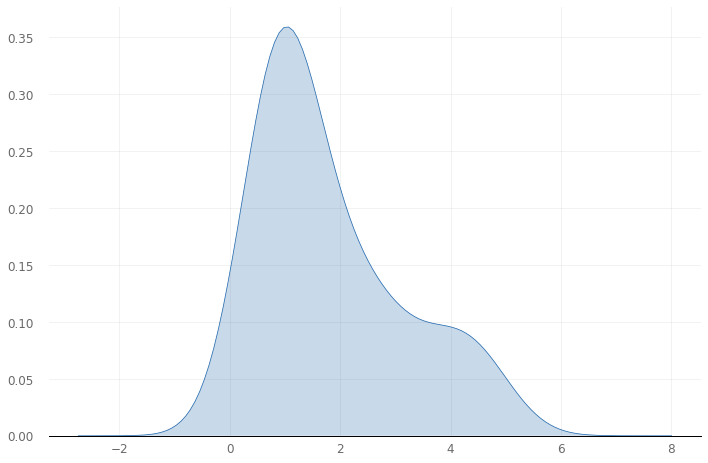

In [0]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_mse')

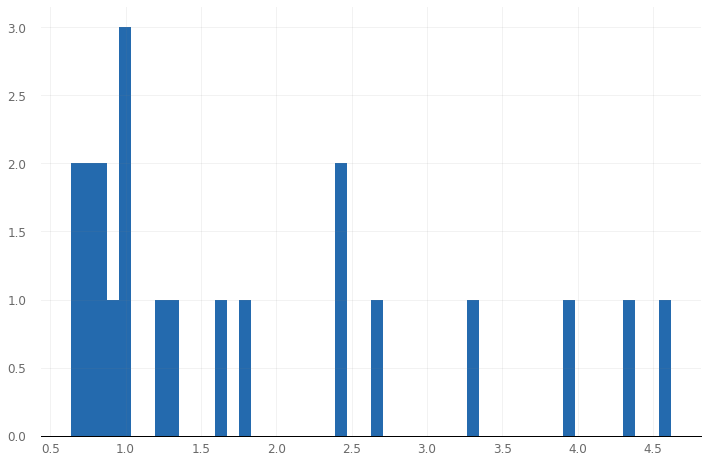

In [0]:
# a simple histogram
analyze_object.plot_hist('val_mse', bins=50)

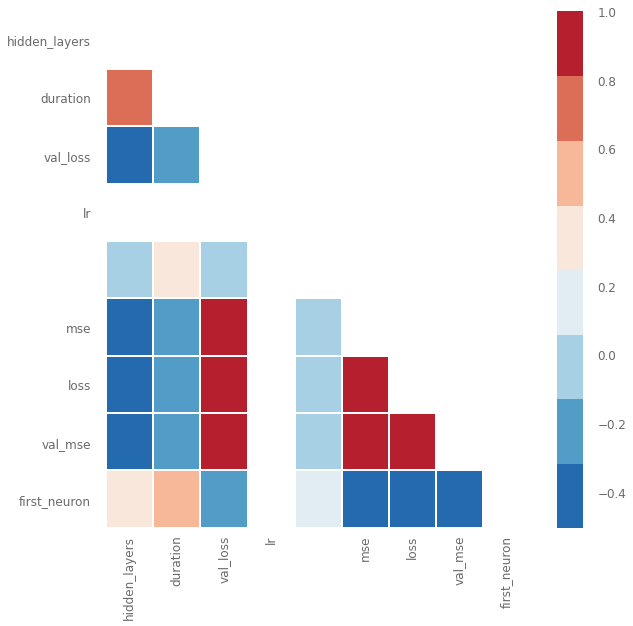

In [0]:
# heatmap correlation
analyze_object.plot_corr(metric='val_mse', 
                         exclude=['epochs', 'round_epochs', 'batch_size', 'dropout'],
                         color_grades=5)

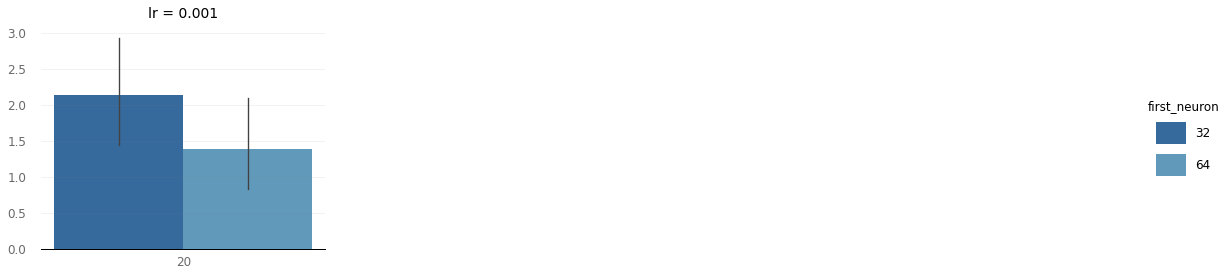

In [0]:
# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_mse', 'first_neuron', 'lr')

### Evaluating data with Evaluate()
Models can be evaluated with Evaluate() against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the Scan process and only exposed into Evaluate once one or more candidate models have been identified.

In [0]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(X_test_scaled, y_test, folds=10, metric='mse', task='continuous')

[1.6583969244789047,
 1.6919705299453403,
 1.6981397160601406,
 1.644793880876976,
 1.631251654854381,
 1.7441988274552942,
 1.6591423796499123,
 1.6709766174638097,
 1.6689021419105154,
 1.6032133408836764]

### Deploying models with Deploy()

Once the right model or models have been found, you can create a deployment package with Deploy() which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of:

* details of the scan
* model weights
* model json
* results of the experiment
* sample of x data
* sample of y data

The Deploy package can be easily restored with Restore() which is covered in the next section.

In [0]:
talos.Deploy(scan_object=scan_object, model_name='houses_deploy3', metric='val_mse');


Deploy package houses_deploy3 have been saved.


### Restoring models with Restore()

The Restore object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the Restore object:

In [0]:
houses_talos = talos.Restore('houses_deploy3.zip')

In [0]:
# get the meta-data for the experiment
houses_talos.details

,0,1
0,experiment_name,my_exp
1,random_method,uniform_mersenne
2,reduction_method,NaN
3,reduction_interval,50
4,reduction_window,20
5,reduction_threshold,0.2
6,reduction_metric,val_mse
7,complete_time,03/29/20/23:19
8,x_shape,"(15480, 8)"
9,y_shape,"(15480,)"


In [0]:
# get the hyperparameter space boundary
houses_talos.params

{'activation': ['relu', 'elu'],
 'batch_size': [20],
 'dropout': [0],
 'epochs': [100],
 'first_neuron': [32, 64],
 'hidden_layers': [1, 2, 3],
 'losses': ['mse', 'mae'],
 'lr': (0.001, 0.01, 0.1, 10, 10),
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam,
  tensorflow.python.keras.optimizer_v2.nadam.Nadam,
  tensorflow.python.keras.optimizer_v2.gradient_descent.SGD],
 'shapes': ['brick']}

In [0]:
# sample of x and y data
houses_talos.x
houses_talos.y

,0
0,1.406
1,0.912
2,1.279
3,1.612
4,1.805
...,...
95,1.079
96,1.172
97,1.716
98,0.608


In [0]:
# the results dataframe
houses_talos.results

,start,end,duration,round_epochs,loss,mse,val_loss,val_mse,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,losses,lr,optimizer,shapes,Unnamed: 19
0,03/29/20-225448,03/29/20-225602,74.184704,100,0.701878,1.005612,0.707667,1.003745,elu,20,0,100,32,3,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick,0
1,03/29/20-225602,03/29/20-225706,63.696198,100,0.729934,0.730945,0.743067,0.744447,elu,20,0,100,64,1,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick,1
2,03/29/20-225706,03/29/20-225825,78.316898,100,1.192151,1.194020,1.257920,1.259226,relu,20,0,100,64,3,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick,2
3,03/29/20-225825,03/29/20-225931,66.415177,100,0.951792,0.953028,0.983768,0.984797,relu,20,0,100,32,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick,3
4,03/29/20-225932,03/29/20-230039,67.255532,100,1.685242,4.186103,1.722976,4.352967,relu,20,0,100,32,1,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.n...,brick,4
5,03/29/20-230039,03/29/20-230143,63.983262,100,2.993923,2.997629,3.319123,3.320611,relu,20,0,100,32,1,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick,5
6,03/29/20-230143,03/29/20-230258,74.553571,100,1.778293,1.780283,1.760582,1.762643,elu,20,0,100,32,3,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.a...,brick,6
7,03/29/20-230258,03/29/20-230403,65.255099,100,0.650136,0.650901,0.694784,0.696294,elu,20,0,100,32,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick,7
8,03/29/20-230403,03/29/20-230517,74.075158,100,0.810759,0.811942,0.903872,0.905537,relu,20,0,100,64,2,mse,0.001,<class 'tensorflow.python.keras.optimizer_v2.n...,brick,8
9,03/29/20-230518,03/29/20-230625,66.990948,100,1.133847,2.307838,1.161780,2.417095,relu,20,0,100,64,2,mae,0.001,<class 'tensorflow.python.keras.optimizer_v2.g...,brick,9


In [0]:
# make predictions with the model
houses_talos.model.predict(houses_talos.x)

array([[-0.30563876],
       [ 0.29604703],
       [ 0.8784391 ],
       [ 0.02225883],
       [ 0.41520113],
       [ 0.9926022 ],
       [-0.0527037 ],
       [ 0.35138342],
       [ 0.23030892],
       [ 0.6004959 ],
       [ 0.47182325],
       [ 0.56174946],
       [-0.11169381],
       [ 1.5043579 ],
       [-0.18459125],
       [ 1.0034773 ],
       [-0.19626853],
       [-0.22220203],
       [ 0.76712906],
       [ 0.5829014 ],
       [ 0.8073291 ],
       [ 0.5863644 ],
       [ 1.3964181 ],
       [ 0.4380223 ],
       [ 0.64853615],
       [ 0.2092759 ],
       [ 0.74188346],
       [ 0.32738543],
       [ 0.77272815],
       [-0.26831818],
       [-0.30281   ],
       [ 0.6465046 ],
       [ 3.1052423 ],
       [ 0.47534296],
       [-0.03845235],
       [-0.36917505],
       [ 0.48842555],
       [ 1.083488  ],
       [-0.10115838],
       [ 0.6692639 ],
       [ 1.0117623 ],
       [ 0.53758216],
       [ 0.13057032],
       [-0.30540386],
       [-0.05971636],
       [ 0

## IN CLASS EXERCISE 1: Hyperparameter tuning using Talos

Build a network in Keras (fitted for Talos) in order to train MNIST with an MLP. You will need to add a last layer with softmax and shape of 10 for output. Decide a dictionary of hyperparameters and test that it runs with Talos Scan. 

Try to achieve good results. Try to share the deployed model with a colleage and run it in their computer.


# Vanishing/Exploding gradients

## Xavier and He Initialization

UUID - #S3C2

In [0]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [0]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [0]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

UUID - #S3C3

In [0]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


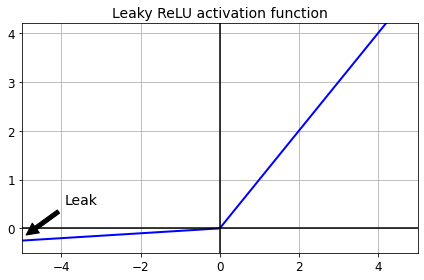

In [0]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [0]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [0]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### ELU

UUID - #S3C4

In [0]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


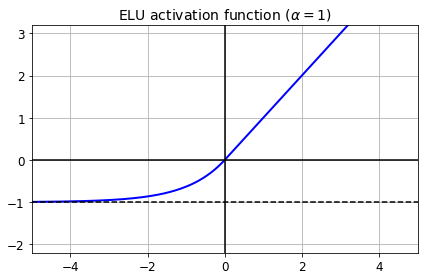

In [0]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [0]:
keras.layers.Dense(10, activation="elu")

### SELU

UUID - #S3C5

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [0]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


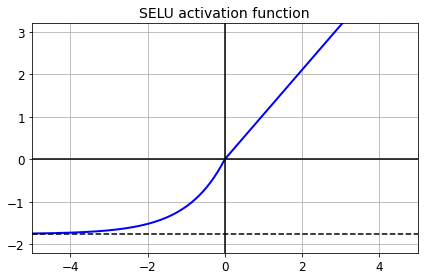

In [0]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [0]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [0]:
# Using SELU is easy
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

### IN CLASS EXERCISE 2: try different activation and normalizations on the Fashion MNIST dataset

Try the following activation functions with their respective initialization parameters:

*   ReLU
*   Leaky ReLU (play with alpha)
*   PReLU
*   SELU

Build a network with at least 50 -100 layers. 
Compare the results and share them with others. You could plot val_loss and loss, and val_acc and acc for instance. Use TensorBoard for that if you can.



Load the dataset like so:

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


#### ReLU
Let's train a neural network on Fashion MNIST using the ReLU:

#### Leaky ReLU
Let's train a neural network on Fashion MNIST using the Leaky ReLU:

#### PReLU
Now let's try PReLU:

#### SELU
Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

# Batch Normalization

UUID - #S3C6

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_425 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_426 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_427 (Dense)            (None, 10)              

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [0]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [0]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5517 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5753 - accuracy: 0.8030 - val_loss: 0.4716 - val_accuracy: 0.8470
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5190 - accuracy: 0.8205 - val_loss: 0.4364 - val_accuracy: 0.8546
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4826 - accuracy: 0.8323 - val_loss: 0.4140 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4565 - accuracy: 0.8406 - val_loss: 0.3984 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4397 - accuracy: 0.8473 - val_loss: 0.3854 - val_accuracy: 0.8692
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4242 - accuracy: 0.8515 - val_loss: 0.3750 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer adds some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [0]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9111 - accuracy: 0.6995 - val_loss: 0.6418 - val_accuracy: 0.7860
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6335 - accuracy: 0.7845 - val_loss: 0.5538 - val_accuracy: 0.8138
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5750 - accuracy: 0.8020 - val_loss: 0.5133 - val_accuracy: 0.8260
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5378 - accuracy: 0.8151 - val_loss: 0.4880 - val_accuracy: 0.8346
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5135 - accuracy: 0.8222 - val_loss: 0.4704 - val_accuracy: 0.8416
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4978 - accuracy: 0.8259 - val_loss: 0.4560 - val_accuracy: 0.8452
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4853 - accuracy: 0.8331 - val_loss: 0.4445 - val_accuracy:

## Gradient Clipping

UUID - #S3C7

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [0]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [0]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# EXERCISES



## EXERCISE 1: hyperparameter tuning on Fashion MNIST

Take everything you have learned in this past 3 sessions and find the best model for Fashion MNIST. We will take into account the speed of training and prediction as well.

## EXERCISE 2: covid19 related

*   **Option 1**: keep on training the Xray images from covid19, but now using Talos hyperparameter optimization, different activation and initializers and batchnorm and clipping when necessary.
*   **Option 2**: take the Covid19 prediction challenge and submit a notebook that uses the advanced techniques discussed until now, i.e. using Talos hyperparameter optimization, different activation and initializers and batchnorm and clipping when necessary.

